# Datathon - Clustering

In [98]:
import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.cluster as skc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import matplotlib.colors as pltc

In [99]:
from skimage import data

For this datathon we'll be working with data about LEGO construction sets. 

LEGO data comes from Rebrickable (https://rebrickable.com) via Kaggle (https://www.kaggle.com/rtatman/lego-database).
The database contains all data in the Rebrickable database for sets released up to mid-2017 (almost all sets ever). 

We're giving you two simplified versions of the larger dataset.

**(File 1) LEGO Colors** — Contains data on all of the different colors of LEGO pieces ever released. 
- Unique pieces = How many different kinds of bricks have been produced in the color.
- Unique sets = How many different LEGO sets have included bricks in the color.
- Unique themes = How many different LEGO themes ("Town", "Space", "Ninjago", "Harry Potter", etc.) have included the color.
- Number of years = How many years have had sets with the color.
- Max set size = How big was the biggest set that includes the color. 
- Median set size = How big was the median set that includes the color.

In [100]:
lego_colors_url = 'https://drive.google.com/uc?export=download&id=1ulFLwT85rHL1zYAitReegEv1bOgQPf24'
lego_colors = pd.read_csv(lego_colors_url,delimiter="\t")
lego_colors.head()

,Color,Number of Unique Pieces,Number of Unique Sets,Number of Unique Themes,Number of Years,Max Set Size,Median Set Size
0,Aqua,55,48,15,10,1305,73
1,Black,4367,8333,373,60,5922,330
2,Blue,1822,5279,342,65,5922,300
3,Blue-Violet,35,17,3,2,987,165
4,Bright Green,257,726,131,24,5200,155


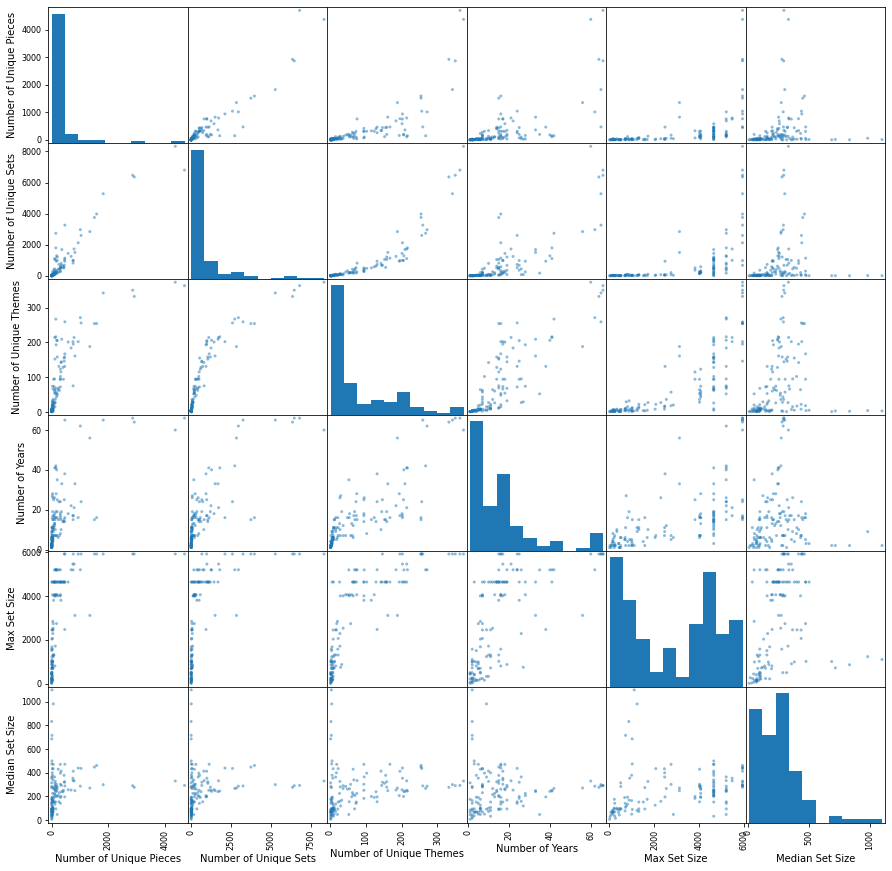

In [101]:
_ = pd.plotting.scatter_matrix(lego_colors, figsize=(15,15))

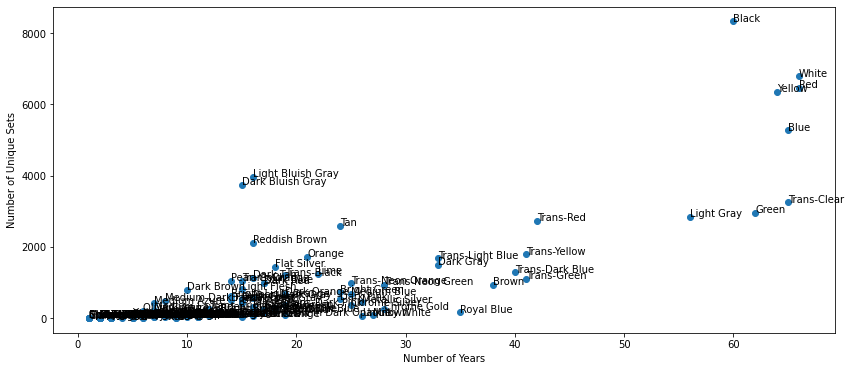

In [102]:
# Plot two dimensions with color names
plt.figure(figsize=(14,6))
plt.scatter(lego_colors["Number of Years"], lego_colors["Number of Unique Sets"])
plt.xlabel('Number of Years')
plt.ylabel('Number of Unique Sets')

for i, row in enumerate(lego_colors.values):
    plt.annotate(row[0],xy=(row[4],row[2]),fontsize=10)

In [103]:
list(lego_colors.columns.values)

['Color',
 'Number of Unique Pieces',
 'Number of Unique Sets',
 'Number of Unique Themes',
 'Number of Years',
 'Max Set Size',
 'Median Set Size']

In [104]:
# Same chart, but in Altair. Note a couple of extremely useful features.
points = alt.Chart(lego_colors).mark_point().encode(
    x="Number of Years",
    y="Number of Unique Sets",
    tooltip=list(lego_colors.columns.values) #👀
  )

text = alt.Chart(lego_colors).mark_text(
    align="left",
    baseline="bottom"  
  ).encode(
    x="Number of Years",
    y="Number of Unique Sets",
    text="Color"
  )

(points + text).properties(
    width=800
  ).interactive() #👀

alt.LayerChart(...)

**(File 2) LEGO Colors by Set** — Contains data on the colors of the pieces in each LEGO set.

- Set Num = A unique alphanumeric ID number for each set. 
- Set Name = The official name of the set (some names are reused for more than one set).
- Year = The year the set was released.
- Num Parts = Total number of parts listed on the box.
- [Colors] = Number of parts of each color in the set, according to the Rebrickable database.

You can also get more data about individual sets by going to http://rebrickable.com/sets/{SetNum}

In [105]:
set_colors_url = 'https://drive.google.com/uc?export=download&id=1zFi7sNXbl_mlPNnBSkkVNryQZqdcOCR5'
set_colors = pd.read_excel(set_colors_url)
set_colors.fillna(0,inplace=True)
set_colors.head()

,Set Num,Set Name,Year,Num Parts,[No Color],Aqua,Black,Blue,Blue-Violet,Bright Green,...,Trans-Very Lt Blue,Trans-Yellow,Unknown,Very Light Bluish Gray,Very Light Gray,Very Light Orange,Violet,White,Yellow,Yellowish Green
0,2015775,Dragon Fortress,2003,741,39.0,0.0,199.0,0.0,0.0,0.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,0.0
1,2015410,Scorpion Palace,2003,354,25.0,0.0,45.0,4.0,0.0,2.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,89.0,20.0,0.0
2,1089-1,Lego Basic Figures - 24 elements,1985,24,24.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015045,Temple of Mount Everest,2003,288,24.0,0.0,67.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,21.0,26.0,0.0
4,2823692,Simple and Motorized Machines Activity Pack,1997,24,24.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
# Names of the color columns in one array
color_column_names = set_colors.columns.values[4:]
color_column_names.size
# color_column_names

131

In [107]:
# Over 10,000 sets and over 100 colors
set_colors.shape

(10713, 135)

In [108]:
set_colors.columns.values[4:]

array(['[No Color]', 'Aqua', 'Black', 'Blue', 'Blue-Violet',
       'Bright Green', 'Bright Light Blue', 'Bright Light Orange',
       'Bright Light Yellow', 'Bright Pink', 'Brown',
       'Chrome Antique Brass', 'Chrome Black', 'Chrome Blue',
       'Chrome Gold', 'Chrome Green', 'Chrome Pink', 'Chrome Silver',
       'Copper', 'Dark Azure', 'Dark Blue', 'Dark Blue-Violet',
       'Dark Bluish Gray', 'Dark Brown', 'Dark Flesh', 'Dark Gray',
       'Dark Green', 'Dark Orange', 'Dark Pink', 'Dark Purple',
       'Dark Red', 'Dark Tan', 'Dark Turquoise', 'Earth Orange',
       'Fabuland Brown', 'Flat Dark Gold', 'Flat Silver', 'Flesh',
       'Glitter Trans-Clear', 'Glitter Trans-Dark Pink',
       'Glitter Trans-Light Blue', 'Glitter Trans-Neon Green',
       'Glitter Trans-Purple', 'Glow In Dark Opaque',
       'Glow In Dark Trans', 'Glow in Dark White', 'Green', 'Lavender',
       'Light Aqua', 'Light Blue', 'Light Bluish Gray', 'Light Flesh',
       'Light Gray', 'Light Green', 'Ligh

In [109]:
set_colors["Agg"] = set_colors[set_colors.columns.values[4:]].agg("sum", axis="columns")


In [110]:
# set_colors[["Set Name", "Set Num", "Num Parts", "Agg"]]

In [111]:
# A quick interactive plot. (Note that Altair can't handle more than 5k points, so this is just a sample.)
# alt.Chart(set_colors.sample(5000)).mark_point().encode(
#     alt.X('Year', scale=alt.Scale(zero=False)),
#     y="Num Parts",
#     tooltip=["Set Name","Set Num:N","Num Parts"]
#   ).properties(
#     width=800
#   ).interactive()

# Questions

1. Using **File 1**, use hierarchical clustering to find groups of colors that have similar characteristics. What **data columns**, **distance metric**, and **distance threshold** do you think give the best result?

2. Using the same data file, use k-means clustering to find groups of colors that have similar characteristics. What **set of data columns** and what **value of k** do you think gives the best result?

3. Using **File 2**, see if you can create a good clustering that finds groupings of sets based on the colors they contain. Are there specific categories of sets that you can identify?
    
    * *Hint 0: This dataset is big enough to break SciPy's hierarchical clustering. If you want to try hierarchical, use the sklearn [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.htm) package instead.*
    * *Hint 1: You might want to avoid very small sets at least to start.* 
    * *Hint 2: You'll also want to consider how you'll visualize your clusters.*

In [112]:
color_url = "https://raw.githubusercontent.com/colinauyeung/599Vis/main/colors.csv"
colors = pd.read_csv(color_url)
# colors.fillna(0,inplace=True)
color_column_names
filtered_colors = colors[colors["name"].isin(color_column_names)]
filtered_colors.reset_index()  
# filtered_colors

,index,id,name,rgb,is_trans
0,1,0,Black,05131D,f
1,2,1,Blue,0055BF,f
2,3,2,Green,237841,f
3,4,3,Dark Turquoise,008F9B,f
4,5,4,Red,C91A09,f
...,...,...,...,...,...
119,125,503,Very Light Gray,E6E3DA,f
120,126,1000,Glow in Dark White,D9D9D9,f
121,127,1001,Medium Violet,9391E4,f
122,128,1002,Glitter Trans-Neon Green,C0F500,t


In [113]:
# https://stackoverflow.com/questions/29643352/converting-hex-to-rgb-value-in-python
def hex2rgb(hex_string):
    r_hex = hex_string[0:2]
    g_hex = hex_string[2:4]
    b_hex = hex_string[4:6]
    return int(r_hex, 16), int(g_hex, 16), int(b_hex, 16)

def label_red(row):
  return hex2rgb(row["rgb"])[0]

def label_green(row):
  return hex2rgb(row["rgb"])[1]

def label_blue(row):
  return hex2rgb(row["rgb"])[2]

filtered_colors["red"] = filtered_colors.apply (lambda row: label_red(row), axis=1)
filtered_colors["green"] = filtered_colors.apply (lambda row: label_green(row), axis=1)
filtered_colors["blue"] = filtered_colors.apply (lambda row: label_blue(row), axis=1)

# filtered_colors

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [114]:
def rgb2xyY(sR, sG, sB):
  var_R = ( sR / 255 )
  var_G = ( sG / 255 )
  var_B = ( sB / 255 )

  if ( var_R > 0.04045 ):
     var_R = pow(( ( var_R + 0.055 ) / 1.055 ),2.4)
  else:
    var_R = var_R / 12.92
  if ( var_G > 0.04045 ):
    var_G = pow(( ( var_G + 0.055 ) / 1.055 ), 2.4)
  else:
    var_G = var_G / 12.92
  if ( var_B > 0.04045 ):
    var_B = pow(( ( var_B + 0.055 ) / 1.055 ),2.4)
  else:
    var_B = var_B / 12.92
  var_R = var_R * 100
  var_G = var_G * 100
  var_B = var_B * 100

  X = var_R * 0.4124 + var_G * 0.3576 + var_B * 0.1805
  Y = var_R * 0.2126 + var_G * 0.7152 + var_B * 0.0722
  Z = var_R * 0.0193 + var_G * 0.1192 + var_B * 0.9505

  x2 = X / (X+Y+Z)
  y2 = Y / (X+Y+Z)
  return x2, y2

def label_x(row):
  return rgb2xyY(row["red"], row["green"], row["blue"])[0]

def label_y(row):
  return rgb2xyY(row["red"], row["green"], row["blue"])[1]

filtered_colors["x"] = filtered_colors.apply (lambda row: label_x(row), axis=1)
filtered_colors["y"] = filtered_colors.apply (lambda row: label_y(row), axis=1)

# filtered_colors

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [115]:
# points = alt.Chart(filtered_colors).mark_point().encode(
#     x="x",
#     y="y",
#     tooltip=list(filtered_colors.columns.values) #👀
#   )

# # text = alt.Chart(lego_colors).mark_text(
# #     align="left",
# #     baseline="bottom"  
# #   ).encode(
# #     x="Number of Years",
# #     y="Number of Unique Sets",
# #     text="Color"
# #   )

# (points).properties(
#     width=800
#   ).interactive() #👀

In [116]:
hex2rgb("D9D9D9")

(217, 217, 217)

In [117]:
df_xy_features = filtered_colors[["x","y"]] # Pull out only using the x & y colums to use for clustering
dist_xy = spd.squareform(spd.pdist(df_xy_features, metric='euclidean'))
dist_xy.shape

(124, 124)

In [118]:
dist_xy[:4,:4]

array([[0.        , 0.11981048, 0.23361528, 0.0555639 ],
       [0.11981048, 0.        , 0.35255633, 0.17167014],
       [0.23361528, 0.35255633, 0.        , 0.18116978],
       [0.0555639 , 0.17167014, 0.18116978, 0.        ]])

In [119]:
# Perform hierarchical clustering and plot the dendrogram.
# Z_xy = sph.linkage(dist_xy, method='centroid')  # obtain the linkage matrix
# _ = sph.dendrogram(Z_xy)  # plot the linkage matrix as a dendrogram
# plt.xlabel('Data Points')
# plt.ylabel('Distance')
# plt.suptitle('Dendrogram: 12-point toy data', 
#              fontweight='bold', fontsize=14);

In [120]:
# color_labels = sph.fcluster(Z_xy, 0.4, criterion='distance') # --- what happens if you use a different distance threshold?
# filtered_colors['cluster_label'] = color_labels
# filtered_colors.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


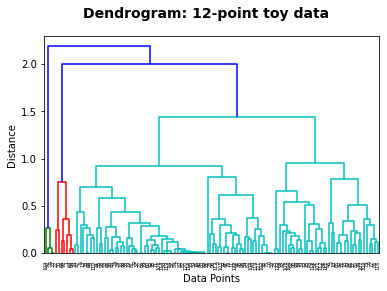

In [121]:
# Perform hierarchical clustering and plot the dendrogram.
Z_xy = sph.linkage(dist_xy, method='average')  # obtain the linkage matrix
_ = sph.dendrogram(Z_xy)  # plot the linkage matrix as a dendrogram
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.suptitle('Dendrogram: 12-point toy data', 
             fontweight='bold', fontsize=14);

In [122]:
color_labels = sph.fcluster(Z_xy, 0.5, criterion='distance') # --- what happens if you use a different distance threshold?
filtered_colors['cluster_label'] = color_labels
filtered_colors.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,name,rgb,is_trans,red,green,blue,x,y,cluster_label
1,0,Black,05131D,f,5,19,29,0.219880,0.249420,8
2,1,Blue,0055BF,f,0,85,191,0.172108,0.139545,3
3,2,Green,237841,f,35,120,65,0.280368,0.475068,14
4,3,Dark Turquoise,008F9B,f,0,143,155,0.218051,0.304953,7
5,4,Red,C91A09,f,201,26,9,0.625280,0.336190,1


In [123]:


# points = alt.Chart(filtered_colors).transform_calculate(
#     url='https://www.color-hex.com/color/' + alt.datum.rgb
# ).mark_point().encode(
#     x="x",
#     y="y",
#     color="cluster_label:N",
#     tooltip=list(filtered_colors.columns.values),
#     href="url:N" #👀
#   )

# # text = alt.Chart(lego_colors).mark_text(
# #     align="left",
# #     baseline="bottom"  
# #   ).encode(
# #     x="Number of Years",
# #     y="Number of Unique Sets",
# #     text="Color"
# #   )

# (points).properties(
#     width=800
#   ).interactive() #👀

In [124]:
type(filtered_colors[filtered_colors["cluster_label"]==1]["name"].tolist())

list

In [125]:
clusters = ["Red Cluster", "Deep Blue Cluster", "Blue Cluster", "Pink Cluster", "Dark Green Cluster", "Light/Near White Cluster", "Light Blue/Black Cluster", "Mid Blue/Black Cluster", "Purple Cluster",
            "Neon Green Cluster", "Yellow Cluster", "Orange Cluster", "Green Cluster", "Yellow-Green Cluster", "Brown Cluster"]
set_colors_mod = set_colors
set_colors_mod["Red Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==1]["name"].tolist()].agg("sum", axis="columns")

set_colors_mod["Deep Blue Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==2]["name"].tolist()].agg("sum", axis="columns")

set_colors_mod["Blue Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==3]["name"].tolist()].agg("sum", axis="columns")

set_colors_mod["Pink Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==4]["name"].tolist()].agg("sum", axis="columns")

set_colors_mod["Dark Green Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==5]["name"].tolist()].agg("sum", axis="columns")

set_colors_mod["Light/Near White Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==6]["name"].tolist()].agg("sum", axis="columns")

set_colors_mod["Light Blue/Black Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==7]["name"].tolist()].agg("sum", axis="columns")

set_colors_mod["Mid Blue/Black Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==8]["name"].tolist()].agg("sum", axis="columns")

set_colors_mod["Purple Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==9]["name"].tolist()].agg("sum", axis="columns")

set_colors_mod["Neon Green Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==10]["name"].tolist()].agg("sum", axis="columns")

set_colors_mod["Yellow Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==11]["name"].tolist()].agg("sum", axis="columns")

set_colors_mod["Orange Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==12]["name"].tolist()+filtered_colors[filtered_colors["cluster_label"]==13]["name"].tolist()].agg("sum", axis="columns")

set_colors_mod["Green Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==14]["name"].tolist()].agg("sum", axis="columns")

set_colors_mod["Yellow-Green Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==15]["name"].tolist()].agg("sum", axis="columns")

set_colors_mod["Brown Cluster"] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==15]["name"].tolist()].agg("sum", axis="columns")

# view = filtered_colors[filtered_colors["cluster_label"]==12]["name"].tolist()
# view = view + filtered_colors[filtered_colors["cluster_label"]==13]["name"].tolist()
# view.append("Orange Cluster");
# view.append("Set Name");

set_colors_mod["Agg"] = set_colors_mod[clusters].agg("sum", axis="columns")

view = ["Set Name", "Set Num", "Num Parts", "Agg", "[No Color]"] + clusters

# set_colors_mod[view]

In [126]:
n = 6
# set_colors_mod[clusters[n-1]] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==n]["name"].tolist()].agg("sum", axis="columns")
view = filtered_colors[filtered_colors["cluster_label"]==n]["name"].tolist()

view.append(clusters[n-1]);
view.append("Set Name");

# set_colors_mod[view]

In [127]:
# n = 13
# set_colors_mod[str(n)] = set_colors_mod[filtered_colors[filtered_colors["cluster_label"]==n]["name"].tolist() + filtered_colors[filtered_colors["cluster_label"]==n-1]["name"].tolist()].agg("sum", axis="columns")
# view = filtered_colors[filtered_colors["cluster_label"]==n]["name"].tolist() + filtered_colors[filtered_colors["cluster_label"]==n-1]["name"].tolist()

# view.append(str(n));
# view.append("Set Name");

# set_colors_mod

In [128]:
listolist = []
for i in range(1,16):
  listolist.append(filtered_colors[filtered_colors["cluster_label"]==i]["name"].tolist())
# listolist

In [129]:
filter = set_colors_mod["Num Parts"] > 100
set_colors[filter].shape

(3897, 151)

In [130]:
filter2 = set_colors['[No Color]'] != set_colors['Num Parts']
set_colors[filter2].shape

(10663, 151)

In [131]:
set_colors[clusters + ["[No Color]"]][filter2 & filter].shape

(3897, 16)

In [132]:
# alt.Chart(set_colors[filter]).mark_point().encode(
#     alt.X('Year', scale=alt.Scale(zero=False)),
#     y="Num Parts",
#     tooltip=["Set Name","Set Num:N","Num Parts"]
#   ).properties(
#     width=800
#   ).interactive()

In [133]:
filteredset = set_colors_mod[filter]
clusteredfilter = filteredset[clusters]
clusteredfilter.reset_index(drop=True)
clusteredfilter.head()

,Red Cluster,Deep Blue Cluster,Blue Cluster,Pink Cluster,Dark Green Cluster,Light/Near White Cluster,Light Blue/Black Cluster,Mid Blue/Black Cluster,Purple Cluster,Neon Green Cluster,Yellow Cluster,Orange Cluster,Green Cluster,Yellow-Green Cluster,Brown Cluster
0,181.0,1.0,0.0,0.0,1.0,168.0,0.0,199.0,0.0,0.0,24.0,2.0,8.0,127.0,127.0
1,16.0,1.0,49.0,0.0,1.0,169.0,0.0,45.0,0.0,0.0,23.0,26.0,13.0,11.0,11.0
3,0.0,0.0,0.0,0.0,0.0,150.0,0.0,67.0,0.0,0.0,28.0,20.0,0.0,5.0,5.0
8,109.0,0.0,56.0,0.0,0.0,132.0,0.0,116.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0
10,59.0,0.0,2.0,0.0,0.0,160.0,0.0,92.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [134]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [135]:
histmodel = skc.AgglomerativeClustering(compute_distances=True, distance_threshold=0, n_clusters=None)
histmodel.fit(filteredset[clusters])
histmodel.get_params()
histmodel.labels_

array([2635, 2308, 2787, ...,    5,    2,    0])

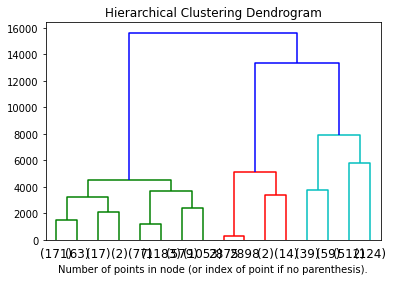

In [136]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(histmodel, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [137]:
# Scale data and convert back to a DataFrame
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
df_scaled = scale.fit_transform(filteredset[clusters])
df_scaled = pd.DataFrame(df_scaled) 
df_scaled.columns = [filteredset[clusters][:0]]
df_scaled.head()

,Red Cluster,Deep Blue Cluster,Blue Cluster,Pink Cluster,Dark Green Cluster,Light/Near White Cluster,Light Blue/Black Cluster,Mid Blue/Black Cluster,Purple Cluster,Neon Green Cluster,Yellow Cluster,Orange Cluster,Green Cluster,Yellow-Green Cluster,Brown Cluster
0,2.089086,-0.069055,-0.585949,-0.187754,-0.124255,-0.035977,-0.195217,0.848504,-0.07717,-0.269002,-0.157662,-0.332072,-0.040936,1.790695,1.790695
1,-0.439332,-0.069055,0.342696,-0.187754,-0.124255,-0.032106,-0.195217,-0.387229,-0.07717,-0.269002,-0.176540,0.117777,0.103406,-0.073508,-0.073508
2,-0.684512,-0.183910,-0.585949,-0.187754,-0.215964,-0.105663,-0.195217,-0.210695,-0.07717,-0.269002,-0.082152,0.005315,-0.271883,-0.169932,-0.169932
3,0.985776,-0.183910,0.475360,-0.187754,-0.215964,-0.175348,-0.195217,0.182492,-0.07717,-0.269002,-0.610726,-0.369560,-0.098673,-0.250286,-0.250286
4,0.219589,-0.183910,-0.548045,-0.187754,-0.215964,-0.066949,-0.195217,-0.010089,-0.07717,-0.269002,-0.591848,-0.369560,-0.271883,-0.250286,-0.250286


In [138]:
set_name = filteredset["Set Name"]
# Run PCA on the feature set dataframe
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
principle_components = pca.fit_transform(df_scaled)

# Stick back into a DataFrame with the original country labels
df_pca = pd.DataFrame(principle_components)
df_pca = pd.concat([df_pca, pd.Series(set_name.array)], axis = 1)
df_pca.columns = ['pc1','pc2','Set Name']
df_pca.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


,pc1,pc2,Set Name
0,1.586615,1.211812,Dragon Fortress
1,-0.324161,0.066292,Scorpion Palace
2,-0.835056,0.364113,Temple of Mount Everest
3,-0.249512,-0.602767,Structures Set
4,-0.825581,0.081685,Technology Activity Set


In [139]:
components = pd.DataFrame(pca.components_)
components.columns = filteredset[clusters].columns
components

,Red Cluster,Deep Blue Cluster,Blue Cluster,Pink Cluster,Dark Green Cluster,Light/Near White Cluster,Light Blue/Black Cluster,Mid Blue/Black Cluster,Purple Cluster,Neon Green Cluster,Yellow Cluster,Orange Cluster,Green Cluster,Yellow-Green Cluster,Brown Cluster
0,0.271137,0.135620,0.307445,0.176537,0.106398,0.377586,0.121177,0.307663,-0.002990,0.199467,0.309274,0.294045,0.238372,0.346729,0.346729
1,-0.360342,0.029029,-0.340525,-0.025303,0.119703,0.075982,0.095226,-0.125548,-0.011704,-0.123021,-0.360404,0.062207,-0.197949,0.509689,0.509689


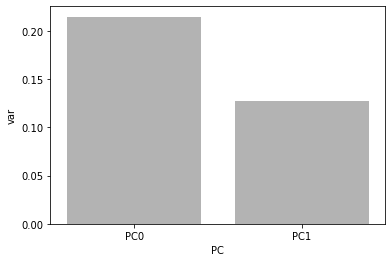

In [140]:
explained_variance = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC'+ str(i) for i in range(pca.n_components_)]})
sns.barplot(x='PC',y="var", data=explained_variance, color='.7');

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


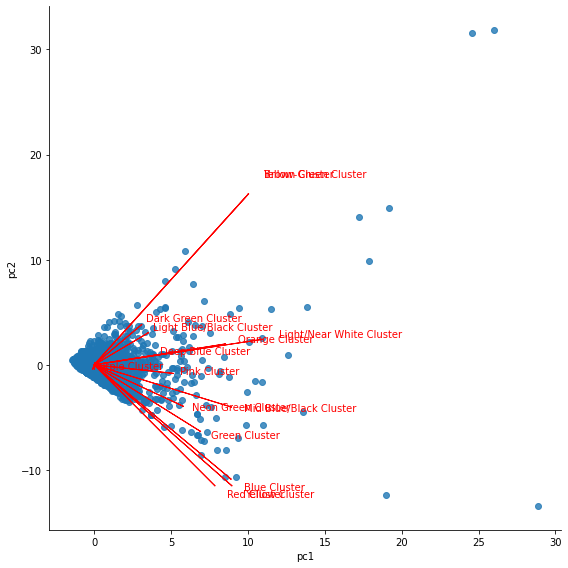

In [141]:
# Plot using the Principle Components as Axes
sns.lmplot(data=df_pca, x='pc1', y='pc2', fit_reg=False, height=8)

# set the maximum variance of the first two PCs
# this will be the end point of the arrow of each **original feature**
xvector = pca.components_[0]
yvector = pca.components_[1]
 
# value of the first two PCs, set the x, y axis boundary
xs = pca.transform(df_scaled)[:,0]
ys = pca.transform(df_scaled)[:,1]

# label countries
# for row in range(0,df_pca.shape[0]):
#      plt.text(df_pca.pc1[row]+0.01, df_pca.pc2[row], 
#      df_pca.country[row], horizontalalignment='left', 
#      size='small', color='grey', weight='light')

# arrows project features (columns from csv) as vectors onto PC axes
for i in range(len(xvector)):
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.005, head_width=0.05)
    plt.text(xvector[i]*max(xs)*1.1, yvector[i]*max(ys)*1.1,
             list(filteredset[clusters].columns.values)[i], color='r')


In [ ]:
# first, plot the observed data
# scatter = alt.Chart(filtereddata).mark_point().encode(
#     x='Player',
#     y='PPM'
# )

# # then, plot the least squares line
rule = alt.Chart(filtereddata3).mark_point().encode(
    x='PPM',
    y='predictions',
    color='Position'
)

line = alt.Chart(X_min_max).mark_line().encode(
    x='X',
    y='Y',
)

# and combine the two in one plot
# scatter + rule
rule + line

**+2 more analysis questions of your own** using either dataset and whatever tool(s) you prefer. 